In [2]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os

Global seed set to 0


You need to change this to suitable directories on your system:

In [3]:
# Data name, where to download data and where to save results
data_name = 'PBMC'
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/PBMC/pbmc68k.h5ad'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/PBMC/'

In [4]:
adata = sc.read_h5ad(data_path)

Load the data and extract most variable genes (and optionally remove some clusters).

In [5]:
adata = sc.read_h5ad(data_path)
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 1000, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 0, n_var_genes= 3000)
# (For some reasons selecting min_shared_counts = 20 removes almost all genes in this dataset, 
# hence we exceptionally set it to 0 here)

Keeping at most 1000 cells per cluster
Extracted 3000 highly variable genes.


In [6]:
adata

AnnData object with n_obs × n_vars = 9359 × 3000
    obs: 'celltype', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    obsm: 'X_tsne', 'X_umap'
    layers: 'spliced', 'unspliced'

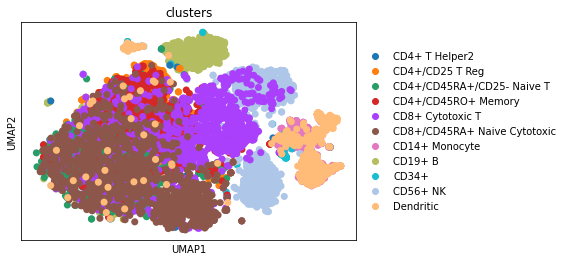

In [7]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='right margin', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

In [8]:
adata

AnnData object with n_obs × n_vars = 9359 × 3000
    obs: 'celltype', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors'
    obsm: 'X_tsne', 'X_umap'
    layers: 'spliced', 'unspliced'

We initialize the model

In [9]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

In [10]:
n_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


2023-04-20 10:52:35.613580: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc-8.2.0/lib64/
2023-04-20 10:52:35.613727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc-8.2.0/lib64/
2023-04-20 10:52:35.613742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Number of Leiden Clusters: 137
Maximal Number of Modules: 157


Louvain clustering seems to give an excessively large number of clusters in this dataset, so instead choose number of modules, based on number of annotated clusters times 1.15:

In [11]:
n_modules = 12

In [12]:
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = n_modules)

Training the model:

In [13]:
mod.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [22:54<00:00,  2.75s/it, v_num=1, elbo_train=1.28e+6]


Exporting relevant model parameters to the anndata object:

In [14]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 9359
Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

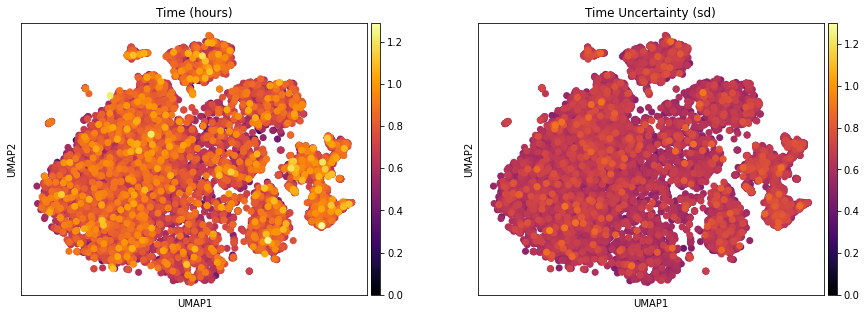

In [15]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1],
              vmin = 0, vmax = 1.3)
plt.savefig(results_path + data_name + 'UMAP_Time_nModules' + str(n_modules) + '.pdf')

Potentially more insightful is the Time coefficient of variation (standard deviation divided by mean):

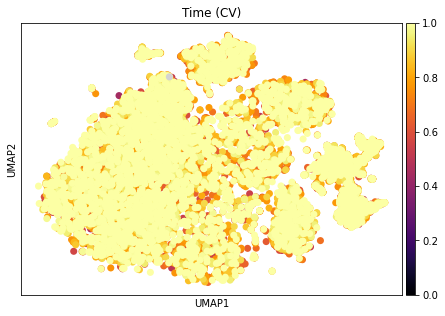

In [17]:
adata.obs['Time (CV)'] = adata.obs['Time Uncertainty (sd)']/adata.obs['Time (hours)']
fig, ax = plt.subplots(1,1, figsize = (7.5, 5))
sc.pl.umap(adata, color = ['Time (CV)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax,
              vmin = 0, vmax = 1)
plt.savefig(results_path + data_name + 'UMAP_CV.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

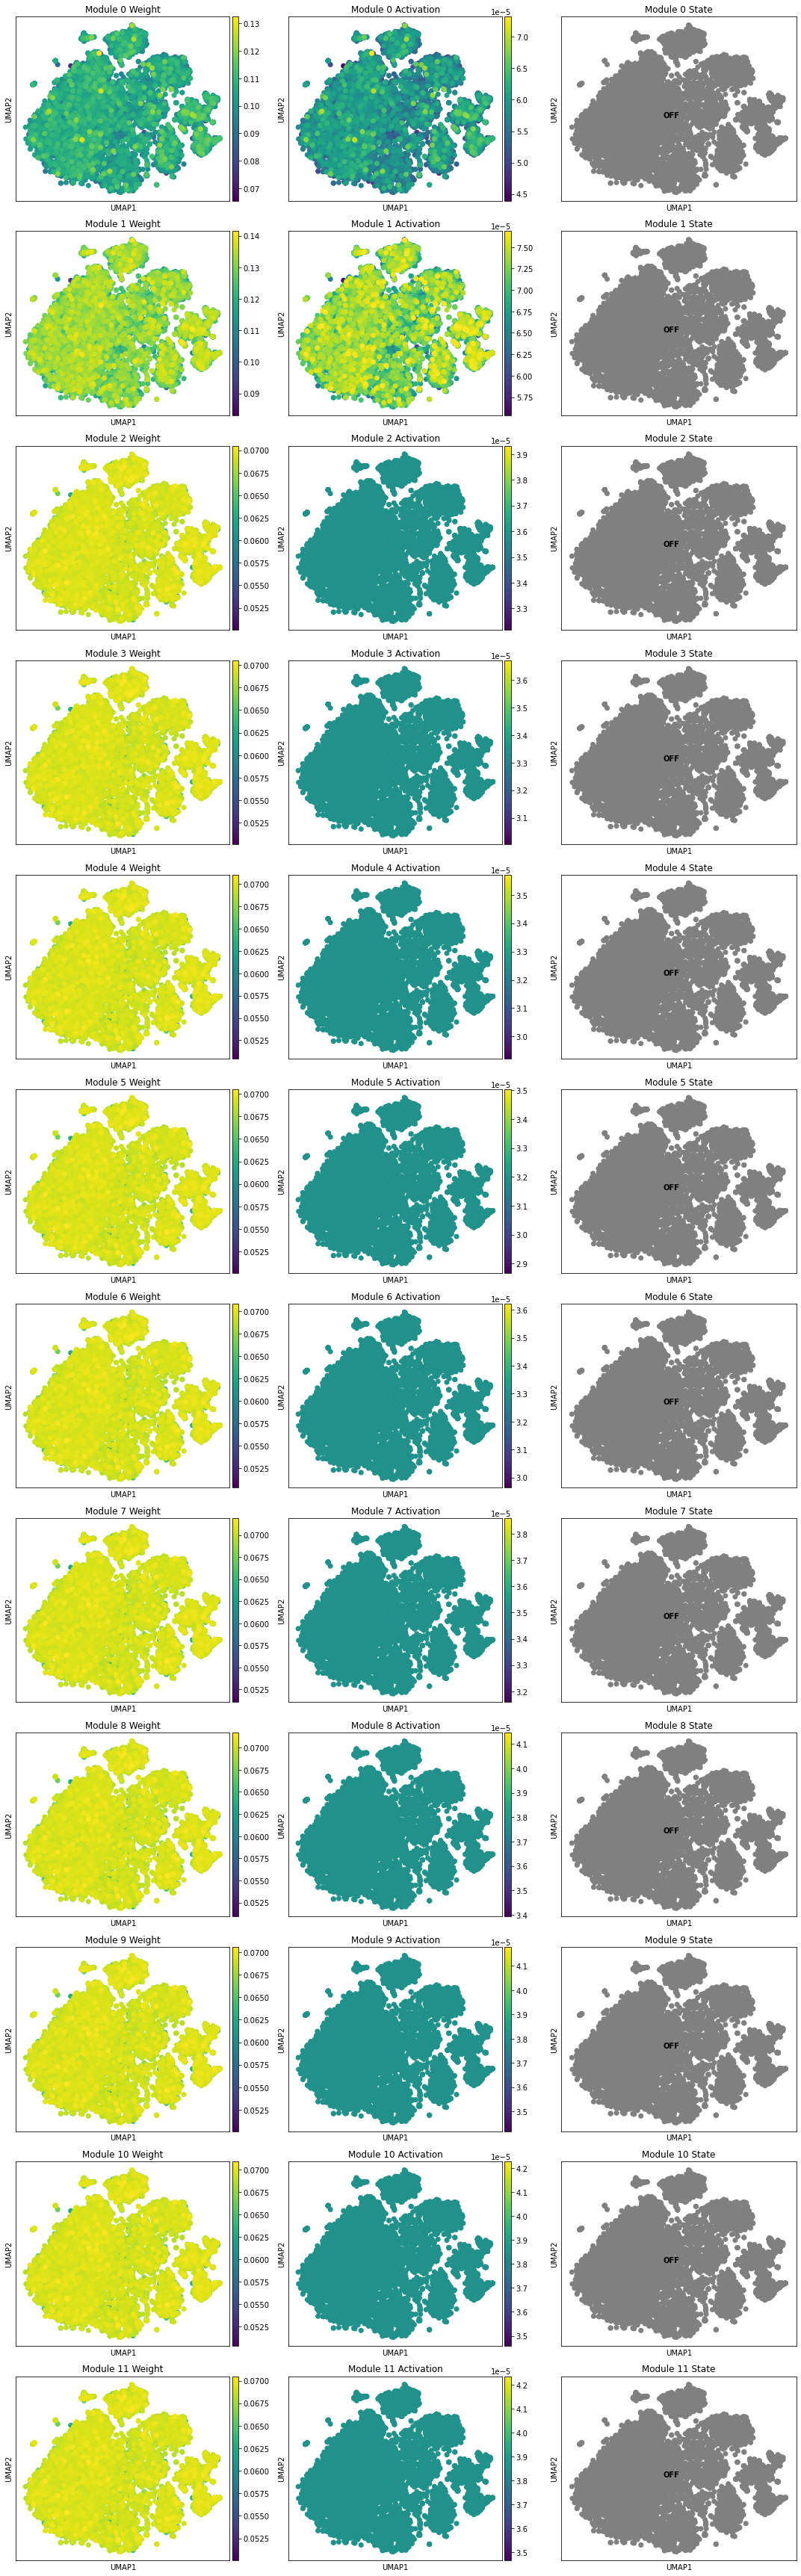

In [15]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

This is an alternative way to visualize module activation over time:

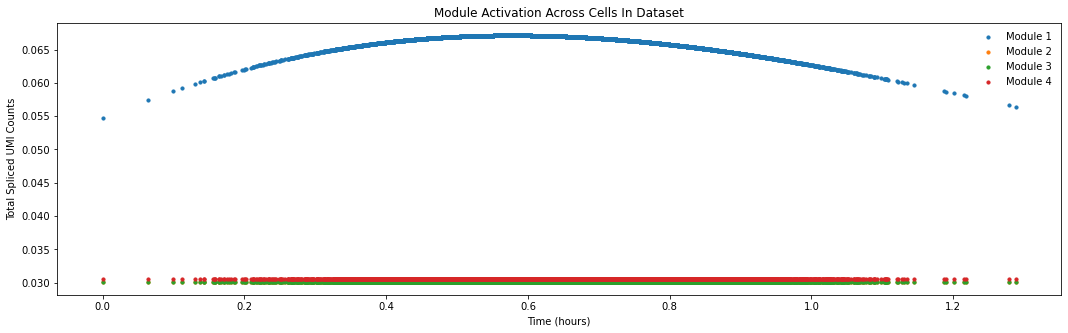

In [16]:
mod.compare_module_activation(adata, chosen_modules = [1,2,3,4],
                         save = results_path + data_name + 'module_activation_comparison.pdf')

Computing Velocity Graph:

Computing total RNAvelocity ...


  0%|          | 0/9359 [00:00<?, ?cells/s]

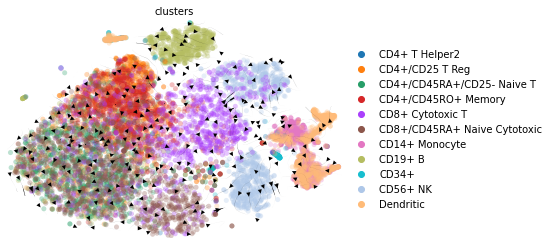

In [23]:
mod.compute_and_plot_total_velocity_scvelo(adata, save = results_path + data_name + 'total_velocity_plots.svg', delete = False)